<a href="https://colab.research.google.com/github/OtusTeam/Machine-Learning/blob/main/%D0%9C%D0%BE%D0%B4%D1%83%D0%BB%D1%8C%207%3A%20Bayesian%20Learning%2C%20PyMC/37_03_BLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[fmendes-DAT263x-demos](https://www.kaggle.com/fmendes/fmendesdat263xdemos)

Correlations between calories burnt, exercise and body type

The prior distributions are:

$\alpha \sim N(\mu=0,\sigma=10)$

$\beta[i] \sim N(\mu=0,\sigma=10)$

, where i=1,2

$\sigma \sim$ half-normal($\sigma$=1)

We define the unobserved variable rate, which is a function of the year:

$\mu=\alpha+\beta[0]∗X1+β[1]∗X2$

Our likelihood function in Bayes theorem is a Poisson distribution on the number of disasters, each year. This can be written as:

$Y \sim N(\mu=\mu,\sigma=\sigma).$

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "sample_data" directory in a colab.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("sample_data"))

# Any results you write to the current directory are saved as output.

['README.md', 'anscombe.json', 'calories.csv', 'exercise.csv', 'mnist_train_small.csv', 'california_housing_train.csv', 'mnist_test.csv', 'california_housing_test.csv']


In [ ]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

# Linear Regression to verify implementation
from sklearn.linear_model import LinearRegression

# Scipy for statistics
import scipy

# PyMC3 for Bayesian Inference
import pymc3 as pm

In [ ]:
data = 'sample_data/'
exercise = pd.read_csv(data + 'exercise.csv')
calories = pd.read_csv(data + 'calories.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df[df['Calories'] < 300]
df = df.reset_index()
df['Intercept'] = 1
df.head()

,index,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Intercept
0,0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,1
1,1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,1
2,2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,1
3,3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,1
4,4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,1


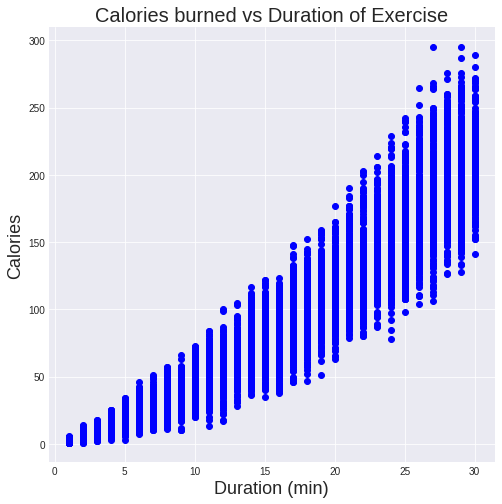

In [ ]:
plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'bo');
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.title('Calories burned vs Duration of Exercise', size = 20);

In [ ]:
# Create the features and response
X = df.loc[:, ['Intercept', 'Duration']]
y = df.loc[:, 'Calories']
print(X.shape, y.shape)

(14998, 2) (14998,)


In [ ]:
X.head()

,Intercept,Duration
0,1,29.0
1,1,14.0
2,1,5.0
3,1,13.0
4,1,10.0


In [ ]:
y.head()

0    231.0
1     66.0
2     26.0
3     71.0
4     35.0
Name: Calories, dtype: float64


### Ordinary linear regression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
oridnary_y_pred = regr.predict(X)

# The coefficients
print('Coefficients: \n',regr.intercept_, regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y, oridnary_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, oridnary_y_pred))

Coefficients: 
 -21.8281025260508 [0.         7.16978335]
Mean squared error: 337.99
Coefficient of determination: 0.91


#### Prediction of Datapoint

In [ ]:
print('Exercising for 15.5 minutes will burn an estimated {:.2f} calories.'.format(
    regr.intercept_ + regr.coef_[1] * 15.5))

Exercising for 15.5 minutes will burn an estimated 89.30 calories.


## Bayesian Linear Regression

Model with 500 Observations

In [ ]:
with pm.Model() as linear_model_500:
    # Intercept
    intercept = pm.Normal('Aga', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[0:499, 'Duration']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values[0:500])
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace_500 = pm.sample(1000, step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, slope, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8905889883663488, but should be close to 0.8. Try to increase the number of tuning steps.


#### Model will all observations

In [ ]:
with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'Duration']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(1000, step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, slope, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.8875435380861684, but should be close to 0.8. Try to increase the number of tuning steps.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


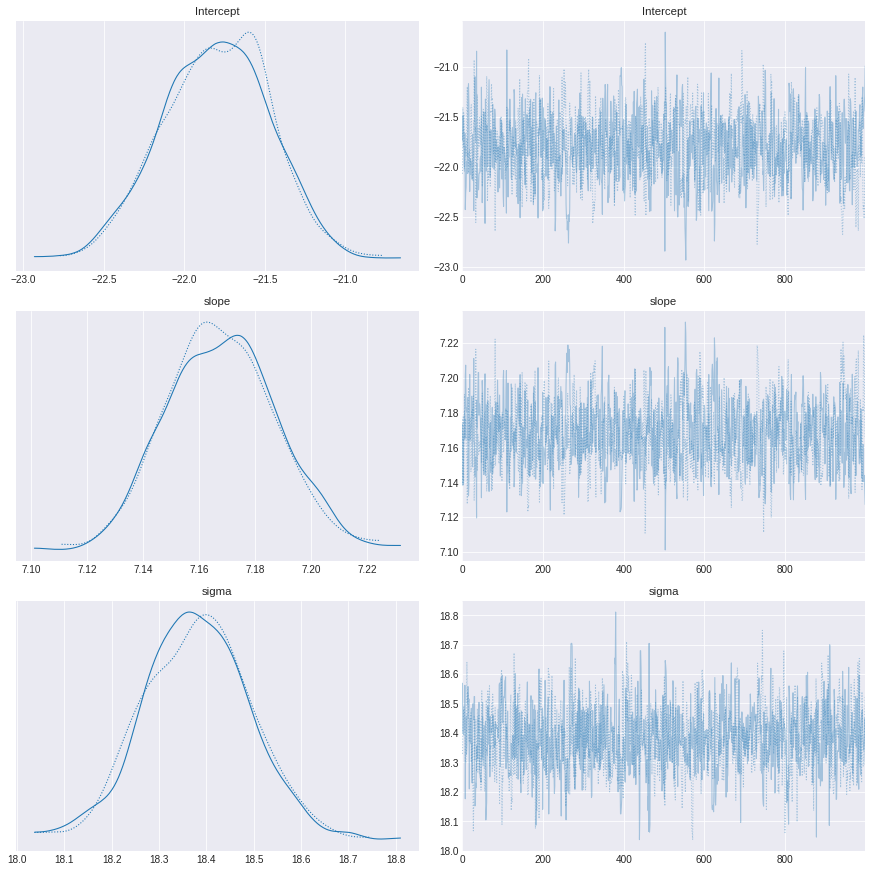

In [ ]:
pm.traceplot(linear_trace, figsize = (12, 12));

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


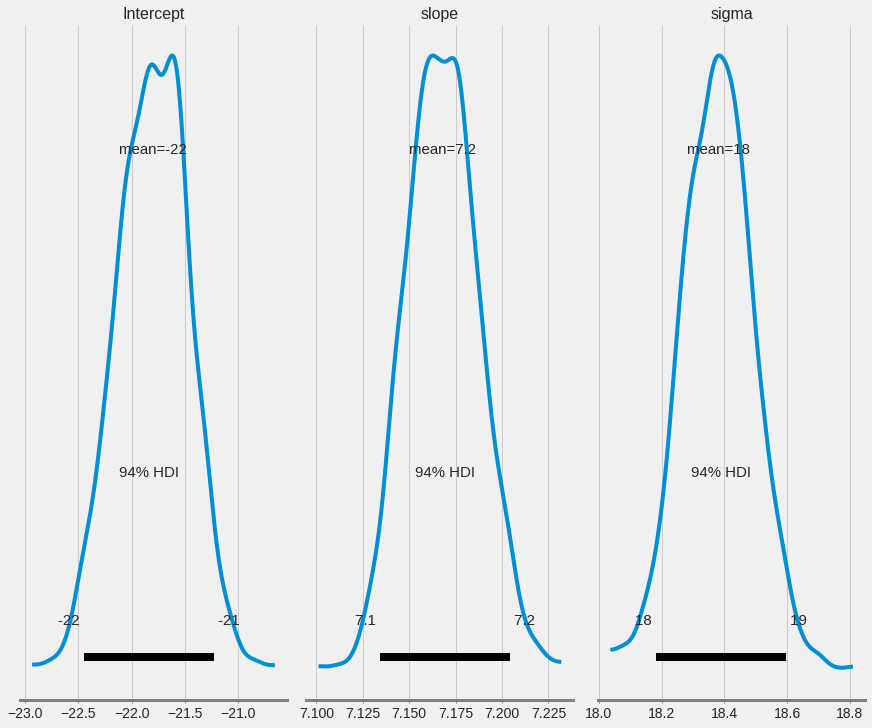

In [ ]:
pm.plot_posterior(linear_trace, figsize = (12, 10));

###Predictions of Response Sampled from the Posterior

#### All observations

/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


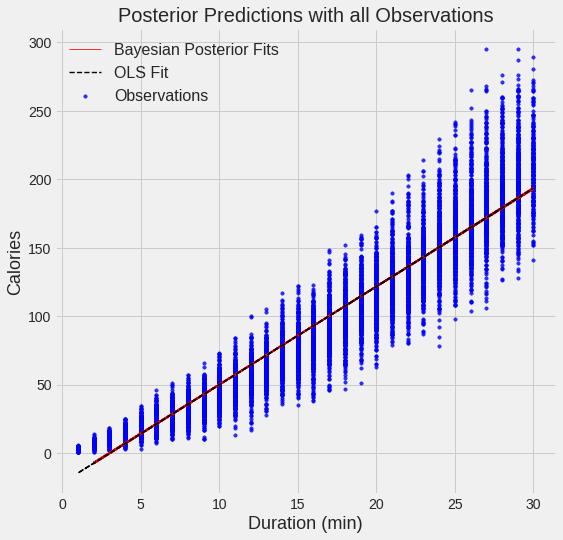

In [ ]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], regr.intercept_ + X['Duration'] * regr.coef_[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with all Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

#### Limited Observations

/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


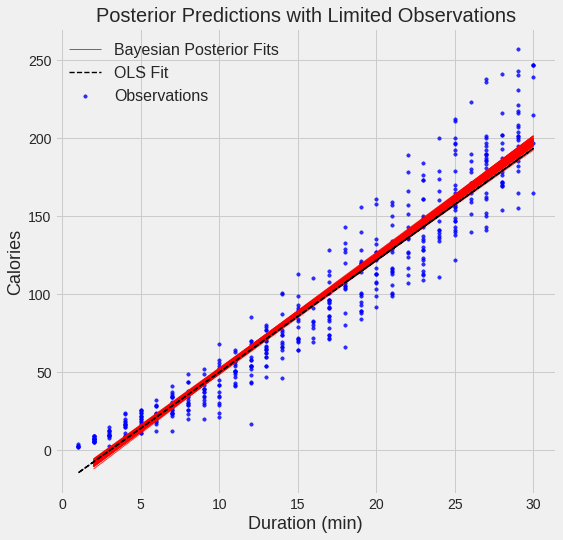

In [ ]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace_500, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'][:500], y.values[:500], s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], regr.intercept_ + X['Duration'] * regr.coef_[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with Limited Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

### Specific Prediction for One Datapoint

In [ ]:
bayes_prediction = linear_trace['Intercept'] + linear_trace['slope'] * 15.5

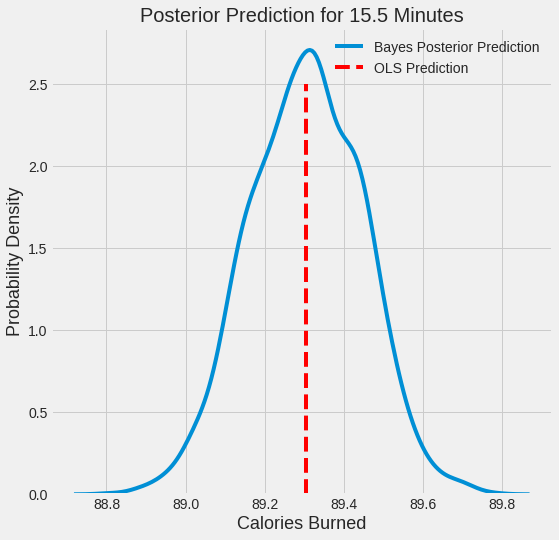

In [ ]:
plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction')
plt.vlines(x = regr.intercept_ + regr.coef_[1] * 15.5, 
           ymin = 0, ymax = 2.5, 
           label = 'OLS Prediction',
          colors = 'red', linestyles='--')
plt.legend();
plt.xlabel('Calories Burned', size = 18), plt.ylabel('Probability Density', size = 18);
plt.title('Posterior Prediction for 15.5 Minutes', size = 20);